In [93]:
# !pip install tensorflow
# !pip list | grep tensorflow
# !pip install opencv-python
# !pip install albumentations
# !pip install torch
# !pip install torchvision
# !pip install cv 
# !pip install ipywidgets

In [94]:
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm
import cv2
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow.compat.v1 as tf
graph_def = tf.compat.v1.GraphDef()
import glob
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from PIL import Image
import random

random.seed(10)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam

# Load Data

In [95]:
DATA_PATH = './tesla_data/'
os.listdir(DATA_PATH)


['.DS_Store', 'test', 'training']

# CNN


In [102]:
DATA_PATH='/Users/aditilakra/Desktop/MSCA (Aashish)/ml project/tesla_data'
train_path = DATA_PATH+'/training'
valid_path = DATA_PATH+'/test'
folders = glob.glob(train_path+'/*')


In [103]:
IMAGE_SIZE = [224, 224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in inception.layers:
    layer.trainable = False
x = Flatten()(inception.output)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=inception.input, outputs=prediction)
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [115]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle = False)
val_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle = False)
r = model.fit_generator(
  training_set,
  validation_data=val_set,
  epochs=2,
  steps_per_epoch=5
)

Found 49 images belonging to 4 classes.
Found 9 images belonging to 4 classes.
Epoch 1/2


2023-05-26 23:13:11.582399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/5 [===========>..................] - ETA: 2s - loss: 0.7344 - accuracy: 0.8980WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.


2023-05-26 23:13:14.641999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5/5 [==============================] - 4s 368ms/step - loss: 0.7344 - accuracy: 0.8980 - val_loss: 4.6350 - val_accuracy: 0.6667


In [116]:
training_set.class_indices

{'go': 0, 'goLeft': 1, 'stop': 2, 'stopLeft': 3}

In [117]:
val_set.class_indices

{'go': 0, 'goLeft': 1, 'stop': 2, 'stopLeft': 3}

In [118]:
batch_size = 32
import sys
def true_and_predicted_labels(dataset):
    labels = np.zeros((dataset.n,4))
    preds = np.zeros_like(labels)
    for i in range(len(dataset)):
        sys.stdout.write('evaluating batch {}\r'.format(i))
        sys.stdout.flush()
        batch = dataset[i]
        batch_images = batch[0]
        batch_labels = batch[1]
        batch_preds = model.predict(batch_images)
        start = i*batch_size
        labels[start:start+batch_size] = batch_labels
        preds[start:start+batch_size] = batch_preds
    return labels, preds

val_labels, val_preds = true_and_predicted_labels(val_set)

a = val_preds
idx = np.argmax(a, axis=-1)
a = np.zeros( a.shape )
a[ np.arange(a.shape[0]), idx] = 1

print(classification_report(val_labels, a))


1/1 [==============================] - 0s 478ms/step
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         3
           1       1.00      0.50      0.67         2
           2       0.75      1.00      0.86         3
           3       0.00      0.00      0.00         1

   micro avg       0.67      0.67      0.67         9
   macro avg       0.56      0.54      0.52         9
weighted avg       0.64      0.67      0.62         9
 samples avg       0.67      0.67      0.67         9



<Axes: >

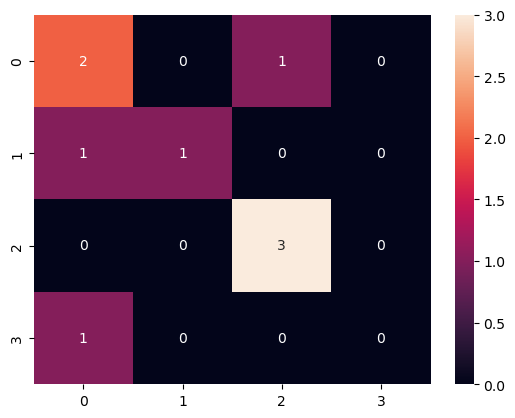

In [119]:
cf_matrix = confusion_matrix(val_labels.argmax(axis=1), a.argmax(axis=1))
sns.heatmap(cf_matrix, annot=True)

1/1 [==============================] - 0s 99ms/step
stop


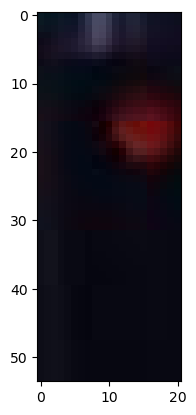

In [144]:
test_img = './temp.jpg'
image = tf.keras.preprocessing.image.load_img(test_img)
im1 = image.resize((224, 224), Image.ANTIALIAS)
input_arr = tf.keras.preprocessing.image.img_to_array(im1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
all_class_names = training_set.class_indices
pos_pred = predictions.argmax() 
key_list = list(all_class_names.keys())
val_list = list(all_class_names.values())
position = val_list.index(pos_pred)
print(key_list[position])
plt.imshow(image)

1/1 [==============================] - 0s 83ms/step
stop


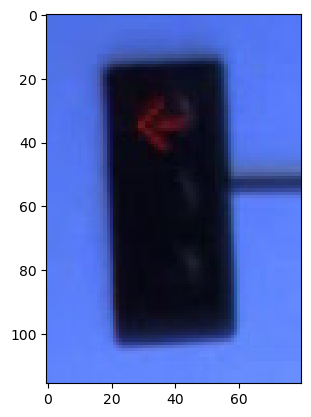

In [147]:
test_img = valid_path+'/stopLeft/stop_left_1.jpg'
image = tf.keras.preprocessing.image.load_img(test_img)
im1 = image.resize((224, 224), Image.ANTIALIAS)
input_arr = tf.keras.preprocessing.image.img_to_array(im1)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
all_class_names = training_set.class_indices
all_class_names
pos_pred = predictions.argmax() 
key_list = list(all_class_names.keys())
val_list = list(all_class_names.values())
position = val_list.index(pos_pred)
print(key_list[position])
plt.imshow(np.asarray(image))